In [1]:
from traitlets.config.manager import BaseJSONConfigManager
cm = BaseJSONConfigManager()
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
            'scroll': True
})

{'theme': 'sky',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'scroll': True}

# Лекция 1. Арифметика чисел с плавающей точкой. Векторные нормы. Матричные нормы. Унитарные матрицы.

## План на сегодня

- Арифметика чисел с фиксированной и плавающей точкой
- Концепция **обратной (backward)** и **прямой (forward)** устойчивости алгоритмов
- Как измерять точность: векторные нормы
- Матричные нормы
- Унитарные матрицы: преобразование Гивенса и Хаусхолдера

## Представление чисел 

- Действительные числа обозначают различные величины: вероятности, массы, скорости, длины...

- Важно знать, как они представляются в компьютере, который оперирует только битами.

## Представление с фиксированной точкой

- Наиболее очевидный формат представления чисел – это формат чисел с **фиксированной точкой**, также известный как **Qm.n** формат

- Число **Qm.n** лежит в отрезке $[-(2^m), 2^m - 2^{-n}]$ и его точность $2^{-n}$.

- Общий размер памяти для хранения такого числа $m + n + 1$ бит.

- Диапазон чисел, представимых таким образом, ограничен.

## Числа с плавающей точкой (floating point numbers)

Числа в памяти компьютера обычно представляются в виде **чисел с плавающей точкой.**

Число с плавающей точкой представляется в виде

$$ \textrm{number} = \textrm{significand} \times \textrm{base}^{\textrm{exponent}},$$

где *significand* – целое число (aka мантисса), *base* – натуральное число (основание) и *exponent* – целое число (может быть отрицательным), например

$$ 1.2 = 12 \cdot 10^{-1}.$$

## Формат фиксированной точки vs формат плавающей точки

**Q**: какие достоинства и недостатки у рассмотренных форматов представления действительных чисел?

**A**: они подходят для большинства случаев.

- Однако, числа с фиксированной точкой представляют числа из фиксированного интервала и ограничивают **абсолютную** точность.

- Числа с плавающей точкой представлют числа с **относительной** точностью и удобны для случаев, когда числа, которые участвуют в вычислениях, имеют различный порядок (например $10^{-1}$ и $10^{5}$).

- На практике, если скорость не критически важна, стоит использовать float32 или float64.

## IEEE 754
В современных компьютерах представление чисел в виде чисел с плавающей точкой регулируется стандартом [IEEE 754](https://en.wikipedia.org/wiki/IEEE_floating_point), который был опубликован в **1985 г.** До этого компьютеры обрабатывали числа с плавающей точкой по-разному!

IEEE 754 содержит следующие элементы:
- Представление чисел с плавающей точкой (как было описано выше), $(-1)^s \times c \times b^q$.
- Две бесконечности $+\infty$ and $-\infty$
- Два типа **NaN**: "тихий" NaN (**qNaN**) and сигнализирующий NaN (**sNaN**) 
    - qNaN не бросает исключение на уровне блока, производящего операции с плавающей точкой, (floating point unit – FPU), до того как вы проверите результат вычислений
    - значение sNaN бросает исключение из FPU, если вы используете это значение в вычислениях. Этот тип NaN может быть полезен для инициализиции
    - C++11 имеет [стандартный интерфейс](https://en.cppreference.com/w/cpp/numeric/math/nan) для создания разных типов NaN
- Правила **округления**
- Правила для операций типа $\frac{0}{0}, \frac{1}{-0}, \ldots$

Возможные значения определяются через
- основание $b$
- точность $p$ - число цифр в записи
- максимально возможное значение $e_{\max}$

и имеет следующие ограничения

- $ 0 \leq c \leq b^p - 1$
- $1 - e_{\max} \leq q + p - 1 \leq e_{\max}$ 

## Два наиболее используемых формата: single & double

Наиболее часто используются следующие форматы: **binary32** и **binary64** (также известные как **single** и **double**).
В последнее время популярность набирают вычисления с половинной точностью **binary16**.

| Формальное название | Другое название | Основание | Число цифр в записи | Emin | Emax |
|------|----------|----------|-------|------|------|
|binary16| half precision  | 2 | 11 | -14 | + 15 |  
|binary32| single precision | 2 | 24 | -126 | + 127 |  
|binary64| double precision | 2|  53|  -1022| +1023|




## Точность и размер памяти 

**Относительная точность** для различных форматов

- половинная точность или float16: $10^{-3} - 10^{-4}$,
- одинарная точность или float32: $10^{-7}-10^{-8}$,
- двойная точность или float64: $10^{-14}-10^{-16}$.

<font color='red'> Crucial note 1: </font> **float16** занимает **2 байта**, **float32** занимает **4 байта**, **float64** занимает **8 байт**

<font color='red'> Crucial note 2: </font> Обычно в "железе" поддерживается одинарная и двойная точность. Для обучения нейросетей становится популярным использовать половинную точность или даже меньше... Подробности [тут](https://arxiv.org/pdf/1905.12334.pdf)

## Влияние формата представления чисел на обучение нейросетей

- Веса в слоях (полносвязном, свёрточном, действие функций активации) могут храниться с различной точностью
- Это важно для повышении энергоэффективности устройств, на которых запускается обученная нейросеть
- Проект [DeepFloat](https://github.com/facebookresearch/deepfloat) от Facebook показывает, как переизобрести операции с плавающей точкой, чтобы они были эффективны для обучения нейросетей, подробности см. в [статье](https://arxiv.org/pdf/1811.01721.pdf)
- Влияние формата представления чисел на значения градиентов активаций

<img width=500, src="./grad_norm_fp16.png">

- И на кривые обучения

<img width=500, src="./train_val_curves.png">

Графики взяты из [этой статьи](https://arxiv.org/pdf/1710.03740.pdf%EF%BC%89%E3%80%82)

## Альтернатива стандарту IEEE 754

Недостатки IEEE 754:
- переполнения до бесконечности или нуля
- много разных NaN
- невидимые ошибки округления (об этом ниже)
- точность либо очень хорошая, либо очень плохая
- субнормальные числа – числа между 0 и минимально возможным представимым числом, то есть мантисса субнормального числа начинается с ведущего 0

Концепция posits может заменить числа с плавающей точкой, см [статью](http://www.johngustafson.net/pdfs/BeatingFloatingPoint.pdf)

<img width=600 src="./posit.png">

- выражают числа с некоторой точностью, но указывают предел изменения
- отсутствуют переполнения до бесконечности или нуля
- пример хранения числа

<img width=600 src="./posit_example.png">

### Пример 1: потеря точности при делении

In [2]:
import numpy as np
import random
#c = random.random()
#print(c)
c = np.float32(0.925924589693)
print(c)
a = np.float32(8.9)
b = np.float32(c / a)
print('{0:10.16f}'.format(b))
print(a * b - c)

0.9259246
0.1040364727377892
-5.9604645e-08


### Пример 2: потеря точности при извлечении корня

In [3]:
#a = np.array(1.585858585887575775757575e-5, dtype=np.float)
a = np.float32(5.0)
b = np.sqrt(a)
print('{0:10.16f}'.format(b ** 2 - a))

0.0000001468220603


### Пример 3: потеря точности при вычислении экспоненты

In [4]:
a = np.array(2.28827272710, dtype=np.float32)
b = np.exp(a)
print(np.log(b) - a)

0.0


## Выводы

- Для некоторых чисел обратные функции дают неточный ответ
- Относительная точность должна сохраняться в соответствии со стандартом IEEE
- Это требование не выполняется на многих современных GPU
- Подробный анализ выполнимости стандарта IEEE 754 на GPU от NVIDIA можно найти [здесь](https://docs.nvidia.com/cuda/floating-point/index.html#considerations-for-heterogeneous-world) 

## Потеря значимых цифр

- Многие операции приводят к потере значимых цифр в результате, этот эффект называется [loss of significance](https://en.wikipedia.org/wiki/Loss_of_significance)
- Например, при вычитании двух близких больших чисел результат будет иметь меньше правильных цифр, чем исходные цифры
- Это связано с алгоритмами и их свойствами (прямой/обратной устойчивости), которые мы обсудим далее

In [5]:
a = np.float64(123456789999999.11)
print(a)
b = np.float64(123456789999998.1)
print(b)
c = a - b
print('{0:10.17f}'.format(c))

123456789999999.11
123456789999998.1
1.01562500000000000


## Алгоритм суммирования

Однако ошибка округления зависит от алгоритма вычисления.

- Рассмотрим простейшую задачу: дано $n$ чисел с плавающей точкой $x_1, \ldots, x_n$  

- Необходимо вычислить их сумму

$$ S = \sum_{i=1}^n x_i = x_1 + \ldots + x_n.$$

- Простейший алгоритм: складывать числа $x_1, \ldots, x_n$ одно за другим

- Какова ошибка такого алгоритма при работе в неточной арифметике?

## Наивный алгоритм

Сложим числа одно за другим: 

$$y_1 = x_1, \quad y_2 = y_1 + x_2, \quad y_3 = y_2 + x_3, \ldots.$$

- В **худшем случае** ошибка пропорциональна $\mathcal{O}(n)$, в то время как **средне-квадратичная** ошибка $\mathcal{O}(\sqrt{n})$.

- **Алгоритм Кахана** (Kahan algorithm) даёт ошибку в худшем случае $\mathcal{O}(1)$ (то есть она не зависит от $n$).  

- <font color='red'> Можете ли вы найти алгоритм с ошибкой $\mathcal{O}(\log n)$? </font>

## Алгоритм Кахана (Kahan summation)

Следующий алгоритм даёт ошибку $2 \varepsilon + \mathcal{O}(n \varepsilon^2)$, где $\varepsilon$ – машинная точность.
```python
s = 0
c = 0
for i in range(len(x)):
    y = x[i] - c
    t = s + y
    c = (t - s) - y
    s = t
```

In [6]:
import math
from numba import jit

n = 10 ** 8
sm = 1e-10
x = np.ones(n, dtype=np.float32) * sm
x[0] = 1.0
true_sum = 1.0 + (n - 1)*sm
approx_sum = np.sum(x)
math_fsum = math.fsum(x)


@jit(nopython=True)
def dumb_sum(x):
    s = np.float32(0.0)
    for i in range(len(x)):
        s = s + x[i]
    return s

@jit(nopython=True)
def kahan_sum(x):
    s = np.float32(0.0)
    c = np.float32(0.0)
    for i in range(len(x)):
        y = x[i] - c
        t = s + y
        c = (t - s) - y
        s = t
    return s
k_sum = kahan_sum(x)
d_sum = dumb_sum(x)
print('Error in np sum: {0:3.1e}'.format(approx_sum - true_sum))
print('Error in Kahan sum: {0:3.1e}'.format(k_sum - true_sum))
print('Error in dumb sum: {0:3.1e}'.format(d_sum - true_sum))
print('Error in math fsum: {0:3.1e}'.format(math_fsum - true_sum))

Error in np sum: 1.9e-04
Error in Kahan sum: -1.3e-07
Error in dumb sum: -1.0e-02
Error in math fsum: 1.3e-10


## Ещё один пример

In [7]:
import numpy as np
test_list = [1, 1e20, 1, -1e20]
print(math.fsum(test_list))
print(np.sum(test_list))
print(1 + 1e20 + 1 - 1e20)

2.0
0.0
0.0


## Выводы по операциям с числами с плавающей точкой

Необходимо быть особенно осторожными при работе с числами с плавающей точкой, поскольку операции с ними могут дать неверный ответ из-за ошибок округления.

Для многих стандартных алгоритмов вопросы устойчивости хорошо изучены и проблемы, связанные с этим, легко обнаруживаются.

## Векторы

- В рамках курса, мы будем работать не с числами, а с векторами
- Вектор в фиксированном базисе размера $n$ может быть представлен как одномерный массив из $n$ чисел.
- Обычно вектор рассматривается, как матрица $n \times 1$, то есть вектор-столбец

**Примеры:** 
- Многочлены степени $\leq n$ образуют линейное пространство.
- Многочлен $ x^3 - 2x^2 + 1$ может быть представлен в виду вектора $\begin{bmatrix}1 \\ -2 \\ 0 \\ 1\end{bmatrix}$ в базисе $\{x^3, x^2, x, 1\}$

## Векторные нормы

- Векторы обычно содержат приближённое описание физических или каких-нибудь других объектов

- Один из главных вопросов – это насколько приближение точное (1%, 10%)

- Что является достаточно точным представлением объектов, конечно, зависит от конкретного приложения. Например:
    - При решении уравнений в частных производных чаще всего встречается точность порядка $10^{-5} - 10^{-10}$
    - В приложениях связанных с обработкой данных иногда точность порядка $80\%$ приемлема при серьёзном зашумлении исходных данных.

## Расстояния и нормы

- Норма – это количественная мера малости вектора, обычно обознается как $\Vert x \Vert$.

Норма должна удовлетворять следующим свойствам:

- $\Vert \alpha x \Vert = |\alpha| \Vert x \Vert$
- $\Vert x + y \Vert \leq \Vert x \Vert + \Vert y \Vert$ (неравенство треугольника)
- Если $\Vert x \Vert = 0$, то $x = 0$

Расстояние между двумя векторами можно определить как норму разности между ними

$$
   d(x, y) = \Vert x - y \Vert.
$$

## Стандартные нормы

Наиболее известная и чаще всего используемая норма – это **евклидова норма**:

$$\Vert x \Vert_2 = \sqrt{\sum_{i=1}^n |x_i|^2},$$

расстояние по которой соответствует расстоянию в реальном мире. Если векторы состоят из комплексных чисел, используются их модули.

## $p$-норма

Евклидова норма или $2$-норма – это частный случай важного класса $p$-норм:

$$
 \Vert x \Vert_p = \Big(\sum_{i=1}^n |x_i|^p\Big)^{1/p}.
$$

Также важны следующие два частных случая :
- Бесконечная норма или Чебышёвская норма определяется как максимальный модуль элемента вектора $x$: 

$$
\Vert x \Vert_{\infty} = \max_i | x_i|
$$

<img src="chebyshev.jpeg" style="height">

- $L_1$ норма определяется как сумма модулей элементов вектора $x$: 

$$
\Vert x \Vert_1 = \sum_i |x_i|
$$

Расстояние, определённое как $L_1$ норма разности между векторами, называется **Манхэттенским расстоянием**

<img src="manhattan.jpeg" style="height">  


## Эквивалентность норм

Все нормы эквивалентны в следующем смысле

$$
   C_1 \Vert x \Vert_* \leq  \Vert x \Vert_{**} \leq C_2 \Vert x \Vert_*
$$  

для некоторых положительных констант $C_1(n), C_2(n)$, $x \in \mathbb{R}^n$ для любых пар норм $\Vert \cdot \Vert_*$ и $\Vert \cdot \Vert_{**}$. Эквивалентность норм означает, что если некоторый вектор мал в одной норме, то он мал и в другой норме. Однако константы могут быть большими.

## Вычисление норм в Python

Пакет NumPy содержит всё необходимое для вычисления норм: функция ```np.linalg.norm```.


In [8]:
import numpy as np
n = 100
a = np.ones(n)
b = a + 1e-3 * np.random.randn(n)
print('Relative error in L1 norm:', np.linalg.norm(a - b, 1) / np.linalg.norm(b, 1))
print('Relative error in L2 norm:', np.linalg.norm(a - b) / np.linalg.norm(b))
print('Relative error in Chebyshev norm:', np.linalg.norm(a - b, np.inf) / np.linalg.norm(b, np.inf))

Relative error in L1 norm: 0.0008498416786543509
Relative error in L2 norm: 0.001056723991554265
Relative error in Chebyshev norm: 0.0030252783065499726


## Единичные диски в различных нормах

- Единичный диск – это множество точек такое что $\Vert x \Vert \leq 1$
- Для евклидовой нормы единичный диск сопадает с обычным диском
- Для других норм единичный диск сильно отличается от привычного нам диска

Text(0.5, 1.0, 'Unit disk in the p-th norm, $p=1$')

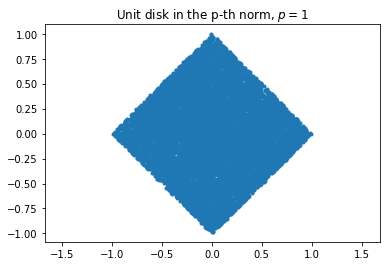

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
p = 1 # Which norm do we use
M = 40000 # Number of sampling points
a = np.random.randn(M, 2)
b = []
for i in range(M):
    if np.linalg.norm(a[i, :], p) <= 1:
        b.append(a[i, :])
b = np.array(b)
plt.plot(b[:, 0], b[:, 1], '.')
plt.axis('equal')
plt.title('Unit disk in the p-th norm, $p={0:}$'.format(p))

## Почему $L_1$ норма может быть важна?

$L_1$ норма играет важную роль в задаче **compressed sensing**. 

Простейшая формулировка этой задачи следующая:

- Даны некоторые наблюдения $f$ 
- Известно, что модель получения наблюдений линейная $Ax = f$, где $A$ – это $n \times m$ известная матрица
- Число уравнений $n$ меньше, чем число неизвестных $m$

**Q**: можем ли мы найти решение такой системы?

Решение, очевидно, не единственно, поэтому естественный подход – это искать решение минимальное в некотором смысле:

\begin{align*}
& \Vert x \Vert \rightarrow \min_x \\
\mbox{subject to } & Ax = f
\end{align*}

- Выбор стандартной евклидовой нормы $\Vert x \Vert = \Vert x \Vert_2$ приводит к **линейной задаче наименьших квадратов**  

- Выбор первой нормы $\Vert x \Vert = \Vert x \Vert_1$ приводит к задаче [**compressed sensing**](https://en.wikipedia.org/wiki/Compressed_sensing)
- Обычно решение этой задачи является наиболее **разреженным** (sparse) решением данной системы 

## Что такое устойчивый алгоритм?

Введём понятия **устойчивости** алгоритма.

- Пусть $x$ некоторый объект, с которым производят операции (например, вектор)
- Пусть $f(x)$ функция от этого объекта, которую необходимо вычислить 

Также имеется **вычислительный алгоритм** ``alg(x)``, который вычисляет некоторую аппроксимацию функции $f(x)$.  

Будем называть алгоритм **forward stable**, если $$\Vert alg(x) - f(x) \Vert  \leq \varepsilon $$  

Будем называть алгоритм **backward stable**, если для любого $x$ найдётся близкий вектор $x + \delta x$ такой что

$$alg(x) = f(x + \delta x)$$

и $\Vert \delta x \Vert$ мало.

## Классический пример

Классическим примером для демонстрации (не)устойчивости алгоритма является задача решения системы линейных уравнений с помощью метода Гаусса, который связан с вычислением LU разложения матрицы (подробности будут далее в курсе).

Рассмотрим **матрицу Гильберта** с элементами

$$A = \{a_{ij}\}, \quad a_{ij} = \frac{1}{i + j + 1}, \quad i,j = 0, \ldots, n-1.$$

и соответствующую линейную систему с этой матрицей

$$Ax = f.$$

In [10]:
import numpy as np
n = 500
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)] # Hilbert matrix
A = np.array(a)
rhs =  np.random.random(n)
sol = np.linalg.solve(A, rhs)
print(np.linalg.norm(A.dot(sol) - rhs)/np.linalg.norm(rhs))
#plt.plot(sol)

7.860287202800179


In [11]:
rhs =  np.ones(n)
sol = np.linalg.solve(A, rhs)
print(np.linalg.norm(A.dot(sol) - rhs)/np.linalg.norm(rhs))
#plt.plot(sol)

4.287160152440011e-08


## Другие примеры неустойчивости

Какой вычислительно устойчивый способ вычисления следующих функций?

- $\log(1 - \tanh^2(x))$
- $SoftMax(x)_j = \dfrac{e^{x_j}}{\sum\limits_{i=1}^n e^{x_i}}$  

In [12]:
u = 300
eps = 1e-6
print("Original function:", np.log(1 - np.tanh(u)**2))
eps_add = np.log(1 - np.tanh(u)**2 + eps)
print("Attempt imporove stability with add small constant:", eps_add)
print("Use more numerically stable form:", np.log(4) - 2 * np.log(np.exp(-u) + np.exp(u)))

Original function: -inf
Attempt imporove stability with add small constant: -13.815510557964274
Use more numerically stable form: -598.6137056388801


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
n = 5
x = np.random.randn(n)
x[0] = 1000
print(np.exp(x) / np.sum(np.exp(x)))
print(np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x))))

[nan  0.  0.  0.  0.]
[1. 0. 0. 0. 0.]


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## Краткое резюме

- Форматы представления действительных чисел и ошибка округления
- Векторные нормы: $1$, $p$ и евклидова норма 
- $L_1$ норма как спопособ получить разреженное решение, задача compressed sensing
- Прямая (forward) и обратная (backward) устойчивость алгоритмов

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()